# Artigo 1 - Running?

## Objetivo
Para essa primeiro artigo, com o objetivo de se aplicar os conhecimentos da primeira lição [Getting Started](https://course.fast.ai/Lessons/lesson1.html) do curso da fastai, se tem como objetivo cirar uma inteligência artifical
que seja seja capaz de classificar imagens, sendo que para esse nicho, foi decidio que ela será treinada para conseguir classificar entre imagens de pessoas andando e pessoas correndo.

## Motivação
Analisar se uma pessoa esta andando ou correndo pode ser de grande utilidade, uma vez que isso ajuda em questões como sistemas de segurança, onde pode ser realizado um monitoramento de trafego.

## Requisitos
Para que se possa realizar a construção da IA precisa de duas coisas, primeiro, dos dados que serão usados tanto para treinar quanto para realizar o teste, que serão adquiridos usando a biblioteca **duckduckgo_search** e da criação da própria IA, que será feito através da biblioteca **fastai**, onde serão instalados na célula 01.

In [2]:
#Explicação de Parâmetros:
#U - Serve para pegar a biblioteca atualizada
#qq - Serve para fazer toda a instalação em silêncio
!pip install -Uqq fastai
!pip install -Uqq duckduckgo_search

## Dados
O próximo passo se da em conseguir os dados para fazer todo o treinamento da IA, para isso sera usado justamente a biblioteca instalada do DuckDuckGo para procurar as imagens, como mostrado na célula 02.

In [20]:
from duckduckgo_search import ddg_images
from fastcore.all import *

# Para facilitar o trabalho, criamos uma função que recebe dois parâmetros:
# Tipo de imagem que esta sendo buscada
# Quantidade de imagem que esta sendo buscado

def search_imagens(term, max_images=300): return L(ddg_images(term, max_results=max_images)).itemgot('image')

Agora podemos testar e ver que tipo de imagens o DuckDuckGo acha, onde para baixar elas, sera usada uma função da biblioteca fastai, onde o processo acontece da seguinte maneira:

* search_imagens: Procura pelas imagens e retorna a Url
* download_url: Baixa a imagens passada pela Url achada pela função search

Como demostrado na célula 03, onde novamente será usado funções da fastai para baixar e vizualizar os dois tipos de imagens.

In [32]:
from fastdownload import download_url
from fastai.vision.all import *

people_walking = search_imagens('People Walking', max_images=1)[0]
people_running = search_imagens('People Running', max_images=1)[0]

download_url(people_walking, 'people_walking.jpg', show_progress=False)
download_url(people_running, 'people_running.jpg', show_progress=False)

Path('people_running.jpg')

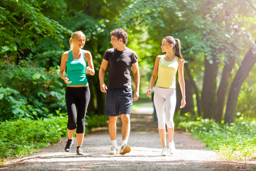

In [33]:
Image.open('people_walking.jpg').to_thumb(256, 256)

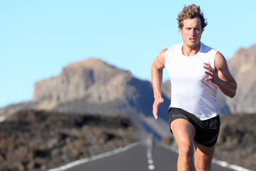

In [34]:
Image.open('people_running.jpg').to_thumb(256, 256)

As buscas forneceram dados satisfatórios, onde se pode diferenciar claramente quando um esta andando e outro está correndo, agora pode se começar a popular os dados que serão usados para treino e teste, salvando cada grupo em um diretório diferente.
Sendo que será usado mais uma função, que é a **sleep**, onde ela é usada para poder evitar problemas no tráfego de imagens

Como definido anteriormente, será pegado 300 de cada tipo de imagem, como pode ser observado na célula 06

In [24]:
from time import sleep

searchs = 'People Walking', 'People Running'
path = Path('walking_or_running')

for people in searchs:
    dest = (path/people)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_imagens(f'{people}'))
    resize_images(path/people, max_size=400, dest=path/people) #Redimensionamento de todas as imagens

/home/daniel-sousa/Documentos/IAs/.venv/lib/python3.10/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Agora antes que possamos treinar o modelo, é preciso verificar se houve algum erro ao baixar alguma imagens, e para isso é usado a função da célula 07 que caso encontre links com erro, irá descartar essas imagens.

In [25]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

## Treinamento do Modelo
Agora que todos os dados foram coletados e os prejudicados foram descartados, pode-se começar a treinar o modelo.
Sendo que para isso, é necessário a criação de **DataLoaders** que é um objeto que vai especificar dois conjuntos, um de imagens usadas para treinamento do modelo e um para validação do modelo, e para a sua criação, será usada o **DataBlock** da biblioteca da **fastai**
Onde o processo pode ser observado na célula 08.

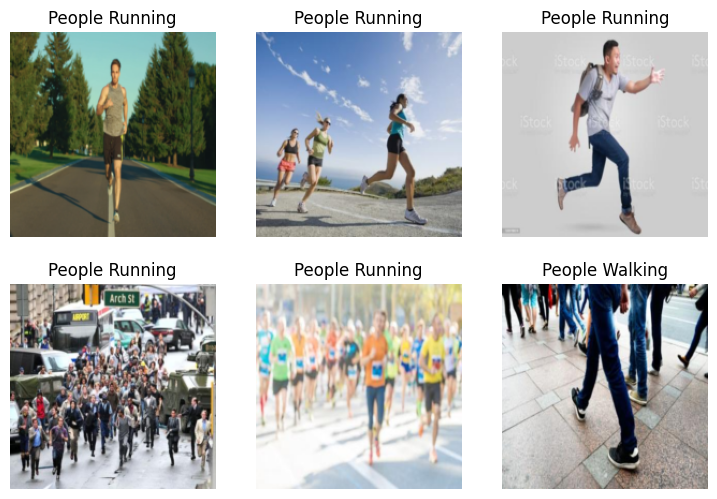

In [26]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # Específica que a entrada são imagens e a saída são elas categorizadas
    get_items=get_image_files,  # Retorna uma lista de todas as imagens
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # Divisão dos conjuntos de treinamento e de validação = 80%/20%
    get_y=parent_label, # Adiciona a label conforme a pasta que está a imagem
    item_tfms=[Resize(192, method='squish')] # Redimensiona as imagens usando o método especificado
).dataloaders(path) # Passando o caminho onde estão as imagens

dls.show_batch(max_n=6) #Vizualização da classificação das imagens

Para o próximo passo é necessário criar o modelo, para isso será usado o modelo de visão computacional **resnet18**, que é um modelo rápido e amplamente utilizado, sendo que para isso sera usado também a função **fine_tune()** da **fastai** que já irá ajustar um modelo pré-treinado utilizando as melhores práticas.

Isso significado que será partido do princípio de um modelo que alguém treinou usando um conjunto de dados e será ajustado os pesos para que se possa se adequar ao conjunto de dados que se deseja usar.

Esse processo pode ser visto na célula 09, onde foram usados três treinamentos, isso para que se possa atingir uma boa precisão, além de parar nesse momento ajuda a ter um modelo treinado e não um decorado.

In [27]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.978072,1.010736,0.358209,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.534112,0.303609,0.104478,00:10
1,0.339391,0.244296,0.074627,00:11
2,0.237887,0.269780,0.089552,00:12


## Utilizando
Agora o modeo será testado em cima das primeiras fotos baixadas, para ver se ele consegu distinguir as imagens, esse teste pode ser encontrado na célula 10 e 11

In [39]:
# Pessoa Correndo
is_running,_,probs = learn.predict(PILImage.create('people_running.jpg'))
print(f"{is_walking}.")
print(f"Probabilidade: {probs[0]:.4f}")

People Running.
Probabilidade: 0.9906


In [40]:
# Pessoa caminhando
is_running,_,probs = learn.predict(PILImage.create('people_walking.jpg'))
print(f"{is_walking}.")
print(f"Probabilidade: {probs[0]:.4f}")

People Running.
Probabilidade: 0.0158


## Conclusão
Pode se observar que o modelo está treinado e está conseguindo indeitifcar com precisão quando se tem pessoas correndo, o que valida o modelo treinado.

## Bibliografia
Course Fastai [Getting Started](https://course.fast.ai/Lessons/lesson1.html)